# Milestone 3: Financial Sentiment Analysis - Complete Implementation
**Team Members:** Nick Cirillo, Suha Memon, Kalen Truong, Bruce Zhang

**Date:** November 2025

---

## Overview
This notebook contains the complete implementation for Milestone 3:
**Component 3:** Strong Baseline (Fine-tuned FinBERT)

---

## Installation & Setup

Install all required packages.

In [ ]:
# Install required packages
!pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn tqdm accelerate -q

print("All packages installed successfully!")

All packages installed successfully!


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# HuggingFace imports
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Libraries imported successfully!
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


## Configuration & File Paths


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Define the path to your project folder within Google Drive, assuming it's a shortcut
# If it's a direct folder, the path might be '/content/drive/MyDrive/NLP Group Project'
# Given it's a shortcut, it's typically found under /content/drive/MyDrive/ and then the shortcut name
project_path = '/content/drive/MyDrive/NLP Group Project'
# project_path = '/content/drive/MyDrive/CIS5300: NLP/NLP Group Project'
# Check if the project path exists. If it's a shortcut, Colab often resolves it under 'MyDrive'.
if not os.path.exists(project_path):
    print(f"Warning: Project path '{project_path}' not found. Please verify the shortcut name and location.")
    print("Attempting to check for a direct folder in MyDrive...")
    project_path = '/content/drive/MyDrive/NLP Group Project'
    if not os.path.exists(project_path):
        print(f"Error: Direct project path '{project_path}' also not found. Please adjust 'project_path' variable.")
    else:
        print("Found project folder as a direct folder in MyDrive.")
else:
    print(f"Found project folder at '{project_path}'.")

# Change current working directory to the project path
# This ensures relative paths for data files work correctly
if os.path.exists(project_path):
    os.chdir(project_path)
    print(f"Current working directory changed to: {os.getcwd()}")
else:
    print("Could not change directory. Please fix the 'project_path'.")

print("Google Drive mounted and directory setup complete.")

Mounted at /content/drive
Found project folder at '/content/drive/MyDrive/NLP Group Project'.
Current working directory changed to: /content/drive/.shortcut-targets-by-id/1PUzV4tiz22wqw70FRtzIQ_ZPFY-5x2kl/NLP Group Project
Google Drive mounted and directory setup complete.


In [ ]:
!ls

 data
'Final Presentation - Financial Sentiment NLP (Draft).pdf'
'Final Presentation - Financial Sentiment NLP.gslides'
 logs
'Milestone 1'
 Milestone2
 Milestone3
 milestone3_finetune_extension.ipynb
 milestone3.md
 models
 output
 proposal


In [ ]:
# File paths - UPDATE THESE TO MATCH YOUR DIRECTORY STRUCTURE
TRAIN_FILE = 'data/train/train.csv'
DEV_FILE = 'data/development/development.csv'
TEST_FILE = 'data/test/test.csv'

# Output directories
OUTPUT_DIR = 'output'
MODEL_DIR = 'models/finbert_finetuned'

# Create directories if they don't exist
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs('logs', exist_ok=True)

# Model configuration
MODEL_NAME = "ProsusAI/finbert"  # Can also use "yiyanghkust/finbert-tone"
NUM_LABELS = 3
MAX_LENGTH = 128

# Label mapping
LABEL_NAMES = ['Negative', 'Neutral', 'Positive']
LABEL_MAP = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

print("Configuration set!")
print(f"Train file: {TRAIN_FILE}")
print(f"Dev file: {DEV_FILE}")
print(f"Test file: {TEST_FILE}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")

Configuration set!
Train file: data/train/train.csv
Dev file: data/development/development.csv
Test file: data/test/test.csv
Output directory: output
Model directory: models/finbert_finetuned


## Data Exploration

Exploring our dataset to understand the class distribution.

In [ ]:
# Load data
train_df = pd.read_csv(TRAIN_FILE)
dev_df = pd.read_csv(DEV_FILE)
test_df = pd.read_csv(TEST_FILE)

print("Dataset Statistics")
print("=" * 50)
print(f"Training samples: {len(train_df)}")
print(f"Development samples: {len(dev_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(dev_df) + len(test_df)}")

print("\nSample Data:")
print(train_df.head())

print("\nColumn Info:")
print(train_df.info())

Dataset Statistics
Training samples: 4673
Development samples: 584
Test samples: 585
Total samples: 5842

Sample Data:
                                            Sentence Sentiment  label
0  A few employees would remain at the Oulu plant...   neutral      1
1  Comparable net sales are expected to increase ...  positive      2
2  Tesla is recalling 2,700 Model X cars: https:/...  negative      0
3  Finnish software developer Done Solutions Oyj ...  positive      2
4  Compagnie de Financement Foncier - Is to issue...   neutral      1

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4673 entries, 0 to 4672
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   4673 non-null   object
 1   Sentiment  4673 non-null   object
 2   label      4673 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 109.7+ KB
None


In [ ]:
# Class distribution analysis
def analyze_class_distribution(df, dataset_name):
    class_counts = df['label'].value_counts().sort_index()

    print(f"\n{dataset_name} Class Distribution:")
    print("=" * 50)
    for label, count in class_counts.items():
        percentage = (count / len(df)) * 100
        print(f"{LABEL_MAP[label]:>8} ({label}): {count:>5} ({percentage:>5.2f}%)")

    return class_counts

train_dist = analyze_class_distribution(train_df, "Training")
dev_dist = analyze_class_distribution(dev_df, "Development")
test_dist = analyze_class_distribution(test_df, "Test")


Training Class Distribution:
Negative (0):   679 (14.53%)
 Neutral (1):  2537 (54.29%)
Positive (2):  1457 (31.18%)

Development Class Distribution:
Negative (0):    81 (13.87%)
 Neutral (1):   309 (52.91%)
Positive (2):   194 (33.22%)

Test Class Distribution:
Negative (0):   100 (17.09%)
 Neutral (1):   284 (48.55%)
Positive (2):   201 (34.36%)


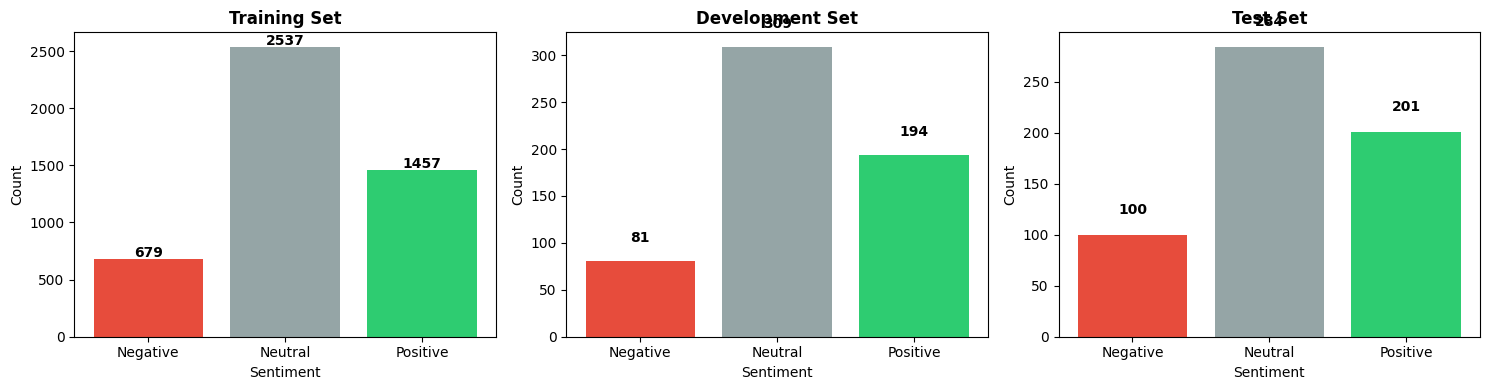

Visualization saved to output/class_distribution.png


In [ ]:
  # Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (df, title) in enumerate([(train_df, 'Training'),
                                     (dev_df, 'Development'),
                                     (test_df, 'Test')]):
    class_counts = df['label'].value_counts().sort_index()
    colors = ['#e74c3c', '#95a5a6', '#2ecc71']  # Red, Gray, Green

    axes[idx].bar([LABEL_MAP[i] for i in class_counts.index],
                  class_counts.values,
                  color=colors)
    axes[idx].set_title(f'{title} Set', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xlabel('Sentiment')

    # Add count labels on bars
    for i, (label, count) in enumerate(zip(class_counts.index, class_counts.values)):
        axes[idx].text(i, count + 20, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {OUTPUT_DIR}/class_distribution.png")

In [ ]:
# Sample headlines from each class
print("\nSample Headlines by Sentiment:")
print("=" * 80)

for label in [0, 1, 2]:
    print(f"\n{LABEL_MAP[label].upper()} Examples:")
    samples = train_df[train_df['label'] == label].sample(min(3, len(train_df[train_df['label'] == label])), random_state=SEED)
    for idx, row in samples.iterrows():
        print(f"  • {row['Sentence'][:100]}..." if len(row['Sentence']) > 100 else f"  • {row['Sentence']}")


Sample Headlines by Sentiment:

NEGATIVE Examples:
  • Kingfisher takeover of Mr Bricolage could hit a brick wall
  • UPDATE 1-Nomura, RBS must pay $806 mln in mortgage bond case-US judge
  • Operating loss totalled EUR 0.3 mn , down from a profit of EUR 5.1 mn in the first half of 2009 .

NEUTRAL Examples:
  • BasWare Invoice Processing , BasWare Contract Matching , BasWare Order Matching and BasWare KPI Repo...
  • To raise consumer awareness and encourage people to recycle their old mobile devices Nokia runs regu...
  • Russia 's Video International Group holds a controlling stake in Russian Media Ventures .

POSITIVE Examples:
  • `` Last year , Finnair recorded a 32.6-percent growth on the Asian sector , carrying more than 1.10 ...
  • And the broker repeated its ` buy ' rating , based on expectations that current restructuring will l...
  • In its financial report , published on Friday , SEB said its net profit soared to SEK6 .745 bn in 20...


---
# Component 1: Evaluation Script

We'll implement our evaluation metrics: Accuracy, F1-Macro, and F1-Weighted.

## Evaluation Metrics Implementation

In [ ]:
def evaluate_predictions(predictions, gold_labels, verbose=True):
    """
    Evaluate predictions against gold standard labels.

    Args:
        predictions: Array of predicted labels (0, 1, 2)
        gold_labels: Array of true labels (0, 1, 2)
        verbose: Whether to print detailed results

    Returns:
        Dictionary containing all metrics
    """
    # Calculate metrics
    accuracy = accuracy_score(gold_labels, predictions)
    f1_macro = f1_score(gold_labels, predictions, average='macro')
    f1_weighted = f1_score(gold_labels, predictions, average='weighted')

    # Per-class metrics
    f1_per_class = f1_score(gold_labels, predictions, average=None)

    # Confusion matrix
    cm = confusion_matrix(gold_labels, predictions)

    if verbose:
        print("=" * 70)
        print("EVALUATION RESULTS")
        print("=" * 70)
        print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"F1-Score (Macro):  {f1_macro:.4f}")
        print(f"F1-Score (Weighted): {f1_weighted:.4f}")

        print("\n" + "=" * 70)
        print("PER-CLASS METRICS")
        print("=" * 70)

        # Detailed classification report
        print(classification_report(
            gold_labels,
            predictions,
            target_names=LABEL_NAMES,
            digits=4
        ))

        print("=" * 70)
        print("CONFUSION MATRIX")
        print("=" * 70)
        print("Rows: True Labels | Columns: Predicted Labels\n")
        print("           Negative  Neutral  Positive")
        for i, row in enumerate(cm):
            print(f"{LABEL_NAMES[i]:>8}   {row[0]:>5}    {row[1]:>5}    {row[2]:>5}")

    results = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm
    }

    return results

print("Evaluation function defined!")

Evaluation function defined!


In [ ]:
def plot_confusion_matrix(cm, title='Confusion Matrix', save_path=None):
    """
    Plot a confusion matrix heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=LABEL_NAMES,
        yticklabels=LABEL_NAMES,
        cbar_kws={'label': 'Count'}
    )
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")

    plt.show()

print("Visualization function defined!")

Visualization function defined!


---
# Extension Attempt 1: Training Strong Baseline (FinBERT) on Training Dataset

Fine-tune FinBERT (BERT pre-trained on financial text) for 3-class sentiment classification.

## Data Preparation for FinBERT

In [ ]:
def prepare_dataset_for_training(df):
    """
    Convert pandas DataFrame to HuggingFace Dataset.

    Args:
        df: DataFrame with 'Sentence' and 'Label' columns

    Returns:
        HuggingFace Dataset object
    """
    # Rename columns to match trainer expectations
    df_copy = df.copy()
    df_copy = df_copy.rename(columns={'Sentence': 'text', 'label': 'label'})

    # Convert to HuggingFace Dataset
    dataset = Dataset.from_pandas(df_copy[['text', 'label']])

    return dataset

print("Preparing datasets for training...")
train_dataset = prepare_dataset_for_training(train_df)
dev_dataset = prepare_dataset_for_training(dev_df)
test_dataset = prepare_dataset_for_training(test_df)

print(f"Train dataset: {len(train_dataset)} examples")
print(f"Dev dataset: {len(dev_dataset)} examples")
print(f"Test dataset: {len(test_dataset)} examples")

print("\nExample from training set:")
print(train_dataset[0])

Preparing datasets for training...
Train dataset: 4673 examples
Dev dataset: 584 examples
Test dataset: 585 examples

Example from training set:
{'text': 'A few employees would remain at the Oulu plant in support functions for other group units .', 'label': 1}


## Load FinBERT Model & Tokenizer

In [ ]:
print("=" * 70)
print("LOADING FINBERT MODEL & TOKENIZER")
print("=" * 70)

print(f"\n Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f" Tokenizer loaded! Vocab size: {len(tokenizer)}")

print(f"\nLoading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True
)

print(f" Model loaded!")
print(f" Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f" Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n Using device: {device}")

LOADING FINBERT MODEL & TOKENIZER

 Loading tokenizer: ProsusAI/finbert


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

 Tokenizer loaded! Vocab size: 30522

Loading model: ProsusAI/finbert


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

 Model loaded!
 Model parameters: 109,484,547
 Trainable parameters: 109,484,547

 Using device: cuda


## Tokenize Data

In [ ]:
def tokenize_function(examples):
    """
    Tokenize text inputs.
    """
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

print("Tokenizing datasets...")
print("This may take a minute...\n")

train_tokenized = train_dataset.map(tokenize_function, batched=True)
dev_tokenized = dev_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

print("Tokenization complete!")

# Show tokenization example
print("\nTokenization Example:")
print(f"Original text: {train_dataset[0]['text'][:100]}...")
print(f"Tokenized (first 20 tokens): {train_tokenized[0]['input_ids'][:20]}")
print(f"Decoded back: {tokenizer.decode(train_tokenized[0]['input_ids'][:20])}")

Tokenizing datasets...
This may take a minute...



Map:   0%|          | 0/4673 [00:00<?, ? examples/s]

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

Map:   0%|          | 0/585 [00:00<?, ? examples/s]

Tokenization complete!

Tokenization Example:
Original text: A few employees would remain at the Oulu plant in support functions for other group units ....
Tokenized (first 20 tokens): [101, 1037, 2261, 5126, 2052, 3961, 2012, 1996, 15068, 7630, 3269, 1999, 2490, 4972, 2005, 2060, 2177, 3197, 1012, 102]
Decoded back: [CLS] a few employees would remain at the oulu plant in support functions for other group units. [SEP]


## Define Training Configuration

In [ ]:
def compute_metrics(eval_pred):
    """
    Compute metrics during training/evaluation.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

# Training arguments
training_args = TrainingArguments(
    output_dir=MODEL_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=SEED,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,  # Only keep best 2 checkpoints
    report_to="none"  # Disable wandb/tensorboard
)

print("=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)
print(f"Learning rate: {training_args.learning_rate}")
print(f"Batch size (train): {training_args.per_device_train_batch_size}")
print(f"Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"Number of epochs: {training_args.num_train_epochs}")
print(f"Weight decay: {training_args.weight_decay}")
print(f"Optimization metric: {training_args.metric_for_best_model}")
# print(f"Early stopping patience: 2 epochs")
print("=" * 70)

TRAINING CONFIGURATION
Learning rate: 2e-05
Batch size (train): 16
Batch size (eval): 32
Number of epochs: 5
Weight decay: 0.01
Optimization metric: f1_macro


## Train FinBERT

This is the first part of our extension for Milestone 3. This is training FinBERT on our data set. This is just the standard training.

In [ ]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=dev_tokenized,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

train_result = trainer.train()

print("\n" + "=" * 70)
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.447900,0.450484,0.792808,0.743219,0.794224
2,0.281700,0.485631,0.815068,0.693057,0.791654
3,0.192400,0.517559,0.827055,0.717874,0.806749



Training time: 343.32 seconds
Training samples/second: 68.06


## Evaluate on Development Set

In [ ]:
print("=" * 70)
print("EVALUATING ON DEVELOPMENT SET")
print("=" * 70 + "\n")

dev_results = trainer.evaluate()

print("\nDevelopment Set Results:")
print("=" * 70)
print(f"Accuracy:          {dev_results['eval_accuracy']:.4f} ({dev_results['eval_accuracy']*100:.2f}%)")
print(f"F1-Score (Macro):  {dev_results['eval_f1_macro']:.4f}")
print(f"F1-Score (Weighted): {dev_results['eval_f1_weighted']:.4f}")
print("=" * 70)

EVALUATING ON DEVELOPMENT SET




Development Set Results:
Accuracy:          0.7928 (79.28%)
F1-Score (Macro):  0.7432
F1-Score (Weighted): 0.7942


## Generate Predictions on Test Set

In [ ]:
test_df.head()

,Sentence,Sentiment,label
0,"The inventors are Mukkavilli Krishna Kiran , S...",neutral,1
1,FCC Chairman Kevin Martin said that fair play ...,neutral,1
2,"Following the issue , the number of shares in ...",neutral,1
3,$IBIO up 10% in premarket ready for lift off,positive,2
4,Vacon 's cash flow from operations grew to EUR...,positive,2


In [ ]:
print("=" * 70)
print("GENERATING TEST SET PREDICTIONS")
print("=" * 70 + "\n")

# Generate predictions
predictions_output = trainer.predict(test_tokenized)
finbert_predictions = np.argmax(predictions_output.predictions, axis=-1)

print(f"Generated {len(finbert_predictions)} predictions")

print("\nSample Predictions:")
print("=" * 70)
for i in range(min(5, len(test_df))):
    text = test_df.iloc[i]['Sentence'][:80] + "..." if len(test_df.iloc[i]['Sentence']) > 80 else test_df.iloc[i]['Sentence']
    pred = LABEL_MAP[finbert_predictions[i]]
    true = LABEL_MAP[test_df.iloc[i]['label']]
    correct = "✓" if pred == true else "✗"
    print(f"{correct} Text: {text}")
    print(f"  Predicted: {pred}, True: {true}\n")

GENERATING TEST SET PREDICTIONS



Generated 585 predictions

Sample Predictions:
✓ Text: The inventors are Mukkavilli Krishna Kiran , Sabharwal Ashutosh and Aazhang Behn...
  Predicted: Neutral, True: Neutral

✓ Text: FCC Chairman Kevin Martin said that fair play required extending the same deregu...
  Predicted: Neutral, True: Neutral

✗ Text: Following the issue , the number of shares in the Swedish company will grow by 9...
  Predicted: Positive, True: Neutral

✓ Text: $IBIO  up 10% in premarket ready for lift off
  Predicted: Positive, True: Positive

✓ Text: Vacon 's cash flow from operations grew to EUR 37.1 mn from EUR 21.9 mn a year a...
  Predicted: Positive, True: Positive



## Evaluate FinBERT on Test Set

In [ ]:
print("\n" + "=" * 70)
print("EVALUATING FINBERT ON TEST SET")
print("=" * 70 + "\n")

finbert_results = evaluate_predictions(
    finbert_predictions,
    test_df['label'].values,
    verbose=True
)

# Save predictions
finbert_output_df = pd.DataFrame({
    'Sentence': test_df['Sentence'],
    'Predicted': finbert_predictions,
    'Gold': test_df['label']
})
finbert_output_path = f'{OUTPUT_DIR}/ms3_strong_baseline_predictions_standard.csv'
finbert_output_df.to_csv(finbert_output_path, index=False)
print(f"\nPredictions saved to {finbert_output_path}")


EVALUATING FINBERT ON TEST SET

EVALUATION RESULTS
Accuracy:          0.7726 (77.26%)
F1-Score (Macro):  0.7456
F1-Score (Weighted): 0.7770

PER-CLASS METRICS
              precision    recall  f1-score   support

    Negative     0.5433    0.6900    0.6079       100
     Neutral     0.8465    0.7570    0.7993       284
    Positive     0.8235    0.8358    0.8296       201

    accuracy                         0.7726       585
   macro avg     0.7378    0.7610    0.7456       585
weighted avg     0.7868    0.7726    0.7770       585

CONFUSION MATRIX
Rows: True Labels | Columns: Predicted Labels

           Negative  Neutral  Positive
Negative      69       21       10
 Neutral      43      215       26
Positive      15       18      168

Predictions saved to output/ms3_strong_baseline_predictions_standard.csv


Confusion matrix saved to output/ms3_strong_baseline_predictions_standard.png


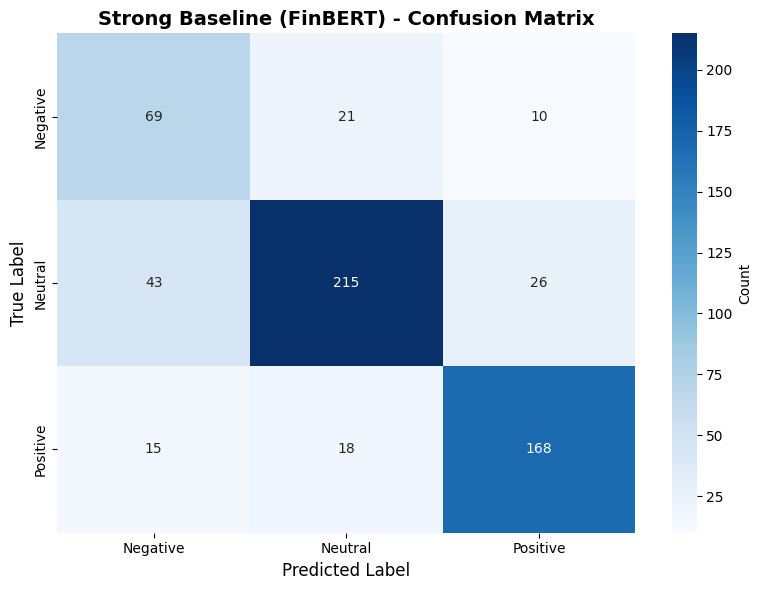

In [ ]:
# Visualize FinBERT confusion matrix
plot_confusion_matrix(
    finbert_results['confusion_matrix'],
    title='Strong Baseline (FinBERT) - Confusion Matrix',
    save_path=f'{OUTPUT_DIR}/ms3_strong_baseline_predictions_standard.png'
)

# Extension Attempt 2: FinBERT with Class Weighting

This approach addresses class imbalance in the financial sentiment dataset by applying inverse frequency weighting to the loss function. The model assigns higher weights to underrepresented classes during training, forcing it to pay more attention to minority class examples (especially Negative sentiment).

In [ ]:
def compute_class_weights(labels):
    """Compute inverse frequency class weights"""
    class_counts = np.bincount(labels)
    total = len(labels)
    weights = total / (len(class_counts) * class_counts)
    return torch.FloatTensor(weights)

class_weights = compute_class_weights(train_df['label'].values)
print("\n" + "=" * 50)
print("CLASS WEIGHTS (for handling imbalance)")
print("=" * 50)
for i, weight in enumerate(class_weights):
    print(f"{LABEL_MAP[i]:>8}: {weight:.4f}")
print("=" * 50)


CLASS WEIGHTS (for handling imbalance)
Negative: 2.2941
 Neutral: 0.6140
Positive: 1.0691


In [ ]:
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply class weights to loss
        loss_fct = nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device)
        )
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
# Using the saem training datasets and tokenized data as above:
print(f"Train dataset: {len(train_dataset)} examples")
print(f"Dev dataset: {len(dev_dataset)} examples")
print(f"Test dataset: {len(test_dataset)} examples")
print("\nTokenization Example:")
print(f"Original text: {train_dataset[0]['text'][:100]}...")
print(f"Tokenized (first 20 tokens): {train_tokenized[0]['input_ids'][:20]}")
print(f"Decoded back: {tokenizer.decode(train_tokenized[0]['input_ids'][:20])}")

Train dataset: 4673 examples
Dev dataset: 584 examples
Test dataset: 585 examples

Tokenization Example:
Original text: A few employees would remain at the Oulu plant in support functions for other group units ....
Tokenized (first 20 tokens): [101, 1037, 2261, 5126, 2052, 3961, 2012, 1996, 15068, 7630, 3269, 1999, 2490, 4972, 2005, 2060, 2177, 3197, 1012, 102]
Decoded back: [CLS] a few employees would remain at the oulu plant in support functions for other group units. [SEP]


In [ ]:
# IMPROVED Training arguments
improved_training_args = TrainingArguments(
    output_dir=MODEL_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,  # INCREASED from 2e-5
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,  # INCREASED from 5
    weight_decay=0.01,
    warmup_ratio=0.1,  # NEW: warmup steps
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=SEED,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    gradient_accumulation_steps=2,  # NEW: effective batch size = 32
    max_grad_norm=1.0,  # NEW: gradient clipping
    fp16=torch.cuda.is_available(),  # NEW: mixed precision training
)

print("\n" + "=" * 70)
print("IMPROVED TRAINING CONFIGURATION")
print("=" * 70)
print(f"Learning rate: {improved_training_args.learning_rate}")
print(f"Batch size (train): {improved_training_args.per_device_train_batch_size}")
print(f"Gradient accumulation: {improved_training_args.gradient_accumulation_steps}")
print(f"Effective batch size: {improved_training_args.per_device_train_batch_size * improved_training_args.gradient_accumulation_steps}")
print(f"Batch size (eval): {improved_training_args.per_device_eval_batch_size}")
print(f"Number of epochs: {improved_training_args.num_train_epochs}")
print(f"Weight decay: {improved_training_args.weight_decay}")
print(f"Warmup ratio: {improved_training_args.warmup_ratio}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Dropout: 0.2")
print(f"Gradient clipping: {improved_training_args.max_grad_norm}")
print(f"Mixed precision: {improved_training_args.fp16}")
print(f"Optimization metric: {improved_training_args.metric_for_best_model}")
print(f"Early stopping patience: 3 epochs")
print(f"CLASS WEIGHTING: ENABLED")
print("=" * 70)


IMPROVED TRAINING CONFIGURATION
Learning rate: 3e-05
Batch size (train): 16
Gradient accumulation: 2
Effective batch size: 32
Batch size (eval): 32
Number of epochs: 10
Weight decay: 0.01
Warmup ratio: 0.1
Max sequence length: 128
Dropout: 0.2
Gradient clipping: 1.0
Mixed precision: True
Optimization metric: f1_macro
Early stopping patience: 3 epochs
CLASS WEIGHTING: ENABLED


In [ ]:
print("\n" + "=" * 70)
print("RELOADING FRESH MODEL FOR IMPROVED TRAINING")
print("=" * 70)

model_improved = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True
)

# Add dropout
model_improved.config.hidden_dropout_prob = 0.2
model_improved.config.attention_probs_dropout_prob = 0.2

print("✓ Fresh model loaded for improved training")

# Then use model_improved instead of model
improved_trainer = WeightedLossTrainer(
    model=model_improved,
    args=improved_training_args,
    train_dataset=train_tokenized,
    eval_dataset=dev_tokenized,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    class_weights=class_weights
)

print("\n" + "=" * 70)
print("STARTING TRAINING - IMPROVED MODEL")
print("=" * 70)

# Train the model
improved_train_result = improved_trainer.train()

print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print("=" * 70)
print(f"Training time: {improved_train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples/second: {improved_train_result.metrics['train_samples_per_second']:.2f}")



RELOADING FRESH MODEL FOR IMPROVED TRAINING
✓ Fresh model loaded for improved training

STARTING TRAINING - IMPROVED MODEL


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.879100,0.510633,0.773973,0.747195,0.786969
2,0.443300,0.466540,0.797945,0.763583,0.804335
3,0.269100,0.546893,0.787671,0.755321,0.800125
4,0.218200,0.710928,0.782534,0.746000,0.795190
5,0.168800,0.768963,0.782534,0.746932,0.794477



TRAINING COMPLETE!
Training time: 203.29 seconds
Training samples/second: 229.87


In [ ]:
# EVALUATE ON DEVELOPMENT SET

print("\n" + "=" * 70)
print("EVALUATING ON DEVELOPMENT SET")
print("=" * 70 + "\n")

dev_results_improved = improved_trainer.evaluate()

print("\nDevelopment Set Results:")
print("=" * 70)
print(f"Accuracy:          {dev_results_improved['eval_accuracy']:.4f} ({dev_results_improved['eval_accuracy']*100:.2f}%)")
print(f"F1-Score (Macro):  {dev_results_improved['eval_f1_macro']:.4f}")
print(f"F1-Score (Weighted): {dev_results_improved['eval_f1_weighted']:.4f}")
print("=" * 70)


EVALUATING ON DEVELOPMENT SET




Development Set Results:
Accuracy:          0.7979 (79.79%)
F1-Score (Macro):  0.7636
F1-Score (Weighted): 0.8043


In [ ]:
# GENERATE TEST PREDICTIONS

print("\n" + "=" * 70)
print("GENERATING TEST SET PREDICTIONS")
print("=" * 70 + "\n")

predictions_improved_output = improved_trainer.predict(test_tokenized)
improved_predictions = np.argmax(predictions_improved_output.predictions, axis=-1)

print(f"Generated {len(improved_predictions)} predictions")

# Show some examples
print("\nSample Predictions:")
print("=" * 70)
for i in range(min(10, len(test_df))):
    text = test_df.iloc[i]['Sentence'][:80] + "..." if len(test_df.iloc[i]['Sentence']) > 80 else test_df.iloc[i]['Sentence']
    pred = LABEL_MAP[improved_predictions[i]]
    true = LABEL_MAP[test_df.iloc[i]['label']]
    correct = "CORRECT" if pred == true else "INCORRECT"
    print(f"{correct} Text: {text}")
    print(f"  Predicted: {pred}, True: {true}\n")


GENERATING TEST SET PREDICTIONS



Generated 585 predictions

Sample Predictions:
CORRECT Text: The inventors are Mukkavilli Krishna Kiran , Sabharwal Ashutosh and Aazhang Behn...
  Predicted: Neutral, True: Neutral

CORRECT Text: FCC Chairman Kevin Martin said that fair play required extending the same deregu...
  Predicted: Neutral, True: Neutral

INCORRECT Text: Following the issue , the number of shares in the Swedish company will grow by 9...
  Predicted: Positive, True: Neutral

CORRECT Text: $IBIO  up 10% in premarket ready for lift off
  Predicted: Positive, True: Positive

CORRECT Text: Vacon 's cash flow from operations grew to EUR 37.1 mn from EUR 21.9 mn a year a...
  Predicted: Positive, True: Positive

CORRECT Text: No financial information was provided .
  Predicted: Neutral, True: Neutral

INCORRECT Text: Sold out $TZA 45 $PUT (down $1), which were hedging my 45 $CALL. Letting the cal...
  Predicted: Negative, True: Positive

CORRECT Text: The operating margin came down to 2.4 % from 5.7 % .
  Predicted:


EVALUATING IMPROVED MODEL ON TEST SET

EVALUATION RESULTS
Accuracy:          0.8017 (80.17%)
F1-Score (Macro):  0.7868
F1-Score (Weighted): 0.8030

PER-CLASS METRICS
              precision    recall  f1-score   support

    Negative     0.5944    0.8500    0.6996       100
     Neutral     0.9510    0.6831    0.7951       284
    Positive     0.7983    0.9453    0.8656       201

    accuracy                         0.8017       585
   macro avg     0.7812    0.8261    0.7868       585
weighted avg     0.8376    0.8017    0.8030       585

CONFUSION MATRIX
Rows: True Labels | Columns: Predicted Labels

           Negative  Neutral  Positive
Negative      85        5       10
 Neutral      52      194       38
Positive       6        5      190

Predictions saved to output/improved_strong_baseline_predictions.csv
Confusion matrix saved to output/improved_confusion_matrix.png


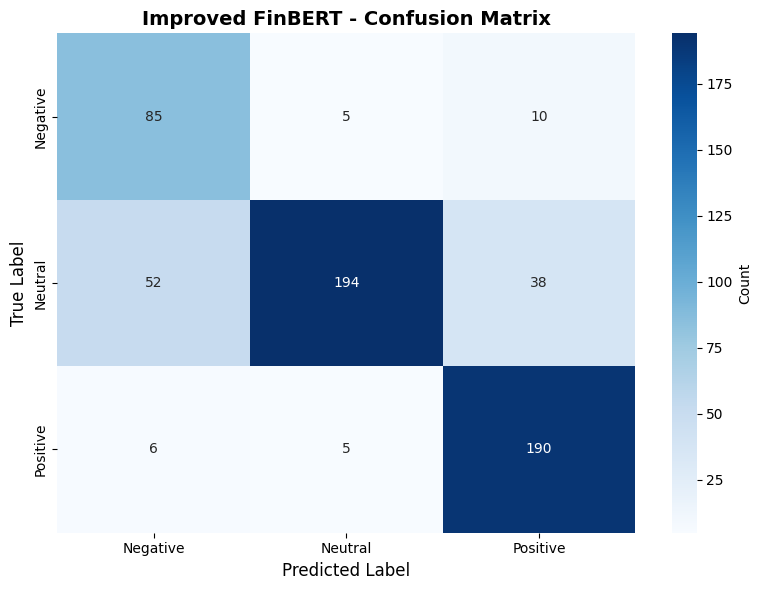

In [ ]:
# EVALUATE ON TEST SET

print("\n" + "=" * 70)
print("EVALUATING IMPROVED MODEL ON TEST SET")
print("=" * 70 + "\n")

improved_results = evaluate_predictions(
    improved_predictions,
    test_df['label'].values,
    verbose=True
)

# Save predictions
improved_output_df = pd.DataFrame({
    'Sentence': test_df['Sentence'],
    'Predicted': improved_predictions,
    'Gold': test_df['label']
})
improved_output_path = f'{OUTPUT_DIR}/improved_strong_baseline_predictions.csv'
improved_output_df.to_csv(improved_output_path, index=False)
print(f"\nPredictions saved to {improved_output_path}")

# Visualize confusion matrix
plot_confusion_matrix(
    improved_results['confusion_matrix'],
    title='Improved FinBERT - Confusion Matrix',
    save_path=f'{OUTPUT_DIR}/improved_confusion_matrix.png'
)

# Comparison of Attempt 1 and Attempt 2:

In [ ]:
# FINAL COMPARISON: STANDARD vs IMPROVED

print("\n" + "=" * 70)
print("FINAL COMPARISON: STANDARD FINETUNED vs IMPROVED FINETUNED FINBERT")
print("=" * 70)

print("\nOVERALL METRICS:")
print("-" * 70)
print(f"{'Metric':<20} {'Standard Finetuned':<15} {'Improved Finetuned':<15} {'Change':<15}")
print("-" * 70)
print(f"{'Accuracy':<20} {finbert_results['accuracy']:.4f} ({finbert_results['accuracy']*100:.2f}%)  {improved_results['accuracy']:.4f} ({improved_results['accuracy']*100:.2f}%)  {(improved_results['accuracy'] - finbert_results['accuracy'])*100:+.2f}%")
print(f"{'F1-Macro':<20} {finbert_results['f1_macro']:.4f}          {improved_results['f1_macro']:.4f}          {improved_results['f1_macro'] - finbert_results['f1_macro']:+.4f}")
print(f"{'F1-Weighted':<20} {finbert_results['f1_weighted']:.4f}          {improved_results['f1_weighted']:.4f}          {improved_results['f1_weighted'] - finbert_results['f1_weighted']:+.4f}")

print("\nPER-CLASS F1 SCORES:")
print("-" * 70)
print(f"{'Class':<20} {'Standard Finetuned':<15} {'Improved Finetuned':<15} {'Change':<15}")
print("-" * 70)
for i, label_name in enumerate(LABEL_NAMES):
    std_f1 = finbert_results['f1_per_class'][i]
    imp_f1 = improved_results['f1_per_class'][i]
    change = imp_f1 - std_f1
    print(f"{label_name:<20} {std_f1:.4f}          {imp_f1:.4f}          {change:+.4f}")

print("\nKEY IMPROVEMENTS:")
print("-" * 70)
if improved_results['f1_per_class'][0] > finbert_results['f1_per_class'][0]:
    improvement = improved_results['f1_per_class'][0] - finbert_results['f1_per_class'][0]
    print(f"Negative class F1 improved by {improvement:.4f} ({improvement*100:.2f}%)")
    print(f"(This addresses the class imbalance issue)")
else:
    print(f"Negative class F1 decreased slightly")

if improved_results['f1_macro'] > finbert_results['f1_macro']:
    improvement = improved_results['f1_macro'] - finbert_results['f1_macro']
    print(f"Macro F1 improved by {improvement:.4f} ({improvement*100:.2f}%)")
    print(f"Better balanced performance across all classes!")
else:
    print(f"Macro F1 decreased slightly")

print("\nALL EXPERIMENTS COMPLETE!")
print(f"Standard Finetuned predictions: {finbert_output_path}")
print(f"Improved Finetuned predictions: {improved_output_path}")
print(f"Visualizations saved to: {OUTPUT_DIR}/")


FINAL COMPARISON: STANDARD FINETUNED vs IMPROVED FINETUNED FINBERT

OVERALL METRICS:
----------------------------------------------------------------------
Metric               Standard Finetuned Improved Finetuned Change         
----------------------------------------------------------------------
Accuracy             0.7726 (77.26%)  0.8017 (80.17%)  +2.91%
F1-Macro             0.7456          0.7868          +0.0412
F1-Weighted          0.7770          0.8030          +0.0260

PER-CLASS F1 SCORES:
----------------------------------------------------------------------
Class                Standard Finetuned Improved Finetuned Change         
----------------------------------------------------------------------
Negative             0.6079          0.6996          +0.0917
Neutral              0.7993          0.7951          -0.0042
Positive             0.8296          0.8656          +0.0360

KEY IMPROVEMENTS:
----------------------------------------------------------------------
N

# Advanced Model Improvements:

In [ ]:
# ============================================================================
# MILESTONE 3 EXTENSION: ADVANCED MODEL IMPROVEMENTS
# Testing the 2 most promising approaches to beat our current 80.17% accuracy
# ============================================================================

print("\n" + "=" * 80)
print("MILESTONE 3 - ADVANCED EXPERIMENTS (TOP 2 APPROACHES)")
print("=" * 80)

# ----------------------------------------------------------------------------
# EXPERIMENT A: FOCAL LOSS (Best for Class Imbalance)
# ----------------------------------------------------------------------------
# Focal Loss specifically targets hard-to-classify examples and addresses
# class imbalance more effectively than standard weighted cross-entropy

print("\n" + "=" * 70)
print("EXPERIMENT A: FOCAL LOSS")
print("=" * 70)

class FocalLoss(nn.Module):
    """
    Focal Loss focuses on hard examples and downweights easy ones.
    gamma=2.0 is the standard value from the paper.
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # class weights
        self.gamma = gamma  # focusing parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)  # probability of correct class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss

class FocalLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = FocalLoss(
            alpha=torch.tensor(self.class_weights).to(logits.device),
            gamma=2.0
        )
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Load fresh model
model_focal = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True
)
model_focal.config.hidden_dropout_prob = 0.2
model_focal.config.attention_probs_dropout_prob = 0.2

focal_training_args = TrainingArguments(
    output_dir='./models/finbert_focal_loss',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=SEED,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    fp16=torch.cuda.is_available(),
)

focal_trainer = FocalLossTrainer(
    model=model_focal,
    args=focal_training_args,
    train_dataset=train_tokenized,
    eval_dataset=dev_tokenized,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    class_weights=list(class_weights.numpy())
)

print("Training Focal Loss model...")
focal_train_result = focal_trainer.train()

print(f"\n✓ Training time: {focal_train_result.metrics['train_runtime']:.2f} seconds")

# Evaluate on dev
focal_dev_results = focal_trainer.evaluate()
print(f"\nDev Set - Accuracy: {focal_dev_results['eval_accuracy']:.4f}, F1-Macro: {focal_dev_results['eval_f1_macro']:.4f}")

# Test predictions WITH FULL PROBABILITIES
focal_predictions_output = focal_trainer.predict(test_tokenized)
focal_predictions = np.argmax(focal_predictions_output.predictions, axis=-1)
focal_logits = focal_predictions_output.predictions  # Save the full logits!

# Convert logits to probabilities
focal_probabilities = torch.nn.functional.softmax(
    torch.tensor(focal_logits), dim=-1
).numpy()

focal_results = evaluate_predictions(
    focal_predictions,
    test_df['label'].values,
    verbose=False
)

print(f"\nTest Set - Accuracy: {focal_results['accuracy']:.4f}, F1-Macro: {focal_results['f1_macro']:.4f}")
print(f"Per-class F1: Negative={focal_results['f1_per_class'][0]:.4f}, "
      f"Neutral={focal_results['f1_per_class'][1]:.4f}, "
      f"Positive={focal_results['f1_per_class'][2]:.4f}")


# ----------------------------------------------------------------------------
# EXPERIMENT B: DISCRIMINATIVE FINE-TUNING (Layer-wise LR)
# ----------------------------------------------------------------------------
# Different learning rates for different layers: lower layers (closer to input)
# learn slower, higher layers learn faster. Often the best approach.

print("\n" + "=" * 70)
print("EXPERIMENT B: DISCRIMINATIVE FINE-TUNING")
print("=" * 70)

def get_parameter_groups_with_decay(model, learning_rate, weight_decay):
    """
    Apply layer-wise learning rate decay.
    Each layer gets 95% of the learning rate of the layer above it.
    """
    no_decay = ["bias", "LayerNorm.weight"]
    num_layers = model.config.num_hidden_layers

    optimizer_grouped_parameters = []

    # Classifier head (highest LR)
    optimizer_grouped_parameters.append({
        "params": [p for n, p in model.classifier.named_parameters()],
        "lr": learning_rate,
        "weight_decay": weight_decay
    })

    # BERT layers (decreasing LR as we go down)
    for layer_num in range(num_layers - 1, -1, -1):
        decay_factor = 0.95 ** (num_layers - layer_num - 1)
        layer_lr = learning_rate * decay_factor

        layer = model.bert.encoder.layer[layer_num]

        # With weight decay
        optimizer_grouped_parameters.append({
            "params": [p for n, p in layer.named_parameters()
                      if not any(nd in n for nd in no_decay)],
            "lr": layer_lr,
            "weight_decay": weight_decay
        })

        # Without weight decay
        optimizer_grouped_parameters.append({
            "params": [p for n, p in layer.named_parameters()
                      if any(nd in n for nd in no_decay)],
            "lr": layer_lr,
            "weight_decay": 0.0
        })

    # Embeddings (lowest LR)
    embedding_lr = learning_rate * (0.95 ** num_layers)
    optimizer_grouped_parameters.append({
        "params": [p for n, p in model.bert.embeddings.named_parameters()],
        "lr": embedding_lr,
        "weight_decay": weight_decay
    })

    return optimizer_grouped_parameters

class DiscriminativeFineTuningTrainer(WeightedLossTrainer):
    def create_optimizer(self):
        if self.optimizer is None:
            optimizer_grouped_parameters = get_parameter_groups_with_decay(
                self.model,
                self.args.learning_rate,
                self.args.weight_decay
            )
            self.optimizer = torch.optim.AdamW(
                optimizer_grouped_parameters,
                lr=self.args.learning_rate,
                betas=(0.9, 0.999),
                eps=1e-8
            )
        return self.optimizer

# Load fresh model
model_discrim = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True
)
model_discrim.config.hidden_dropout_prob = 0.2
model_discrim.config.attention_probs_dropout_prob = 0.2

discrim_training_args = TrainingArguments(
    output_dir='./models/finbert_discriminative',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,  # Max LR for top layers
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=SEED,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    fp16=torch.cuda.is_available(),
)

discrim_trainer = DiscriminativeFineTuningTrainer(
    model=model_discrim,
    args=discrim_training_args,
    train_dataset=train_tokenized,
    eval_dataset=dev_tokenized,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    class_weights=class_weights
)

print("Training Discriminative Fine-tuning model...")
discrim_train_result = discrim_trainer.train()

print(f"\n✓ Training time: {discrim_train_result.metrics['train_runtime']:.2f} seconds")

# Evaluate on dev
discrim_dev_results = discrim_trainer.evaluate()
print(f"\nDev Set - Accuracy: {discrim_dev_results['eval_accuracy']:.4f}, F1-Macro: {discrim_dev_results['eval_f1_macro']:.4f}")

# Test predictions WITH FULL PROBABILITIES
discrim_predictions_output = discrim_trainer.predict(test_tokenized)
discrim_predictions = np.argmax(discrim_predictions_output.predictions, axis=-1)
discrim_logits = discrim_predictions_output.predictions

# Convert logits to probabilities
discrim_probabilities = torch.nn.functional.softmax(
    torch.tensor(discrim_logits), dim=-1
).numpy()

discrim_results = evaluate_predictions(
    discrim_predictions,
    test_df['label'].values,
    verbose=False
)

print(f"\nTest Set - Accuracy: {discrim_results['accuracy']:.4f}, F1-Macro: {discrim_results['f1_macro']:.4f}")
print(f"Per-class F1: Negative={discrim_results['f1_per_class'][0]:.4f}, "
      f"Neutral={discrim_results['f1_per_class'][1]:.4f}, "
      f"Positive={discrim_results['f1_per_class'][2]:.4f}")


# ============================================================================
# FINAL COMPARISON
# ============================================================================

print("\n" + "=" * 80)
print("FINAL COMPARISON: ALL MODELS")
print("=" * 80)

results_comparison = {
    'Baseline (Your Improved)': improved_results,
    'Experiment A (Focal Loss)': focal_results,
    'Experiment B (Discriminative FT)': discrim_results
}

print("\nOVERALL METRICS:")
print("-" * 80)
print(f"{'Model':<30} {'Accuracy':<12} {'F1-Macro':<12} {'F1-Weighted':<12}")
print("-" * 80)

best_model_name = None
best_f1_macro = 0

for model_name, results in results_comparison.items():
    acc = results['accuracy']
    f1_m = results['f1_macro']
    f1_w = results['f1_weighted']

    marker = ""
    if f1_m > best_f1_macro:
        best_f1_macro = f1_m
        best_model_name = model_name
        marker = " ← BEST"

    print(f"{model_name:<30} {acc:.4f}       {f1_m:.4f}       {f1_w:.4f}{marker}")

print("\nPER-CLASS F1 SCORES:")
print("-" * 80)
print(f"{'Model':<30} {'Negative':<12} {'Neutral':<12} {'Positive':<12}")
print("-" * 80)

for model_name, results in results_comparison.items():
    f1_neg = results['f1_per_class'][0]
    f1_neu = results['f1_per_class'][1]
    f1_pos = results['f1_per_class'][2]

    print(f"{model_name:<30} {f1_neg:.4f}       {f1_neu:.4f}       {f1_pos:.4f}")

print("\n" + "=" * 80)
print(f"BEST MODEL: {best_model_name}")
print(f"F1-Macro: {best_f1_macro:.4f}")
print("=" * 80)

# Determine which trainer and probabilities to save
best_trainer_map = {
    'Baseline (Your Improved)': improved_trainer,
    'Experiment A (Focal Loss)': focal_trainer,
    'Experiment B (Discriminative FT)': discrim_trainer
}

best_probs_map = {
    'Baseline (Your Improved)': torch.nn.functional.softmax(
        torch.tensor(predictions_improved_output.predictions), dim=-1
    ).numpy(),
    'Experiment A (Focal Loss)': focal_probabilities,
    'Experiment B (Discriminative FT)': discrim_probabilities
}

best_trainer = best_trainer_map[best_model_name]
best_probabilities = best_probs_map[best_model_name]

# Save the best model for deployment
print(f"\nSaving best model ({best_model_name}) for deployment...")

FINAL_MODEL_DIR = './models/finbert_final_for_deployment'
os.makedirs(FINAL_MODEL_DIR, exist_ok=True)

best_trainer.model.save_pretrained(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)

print(f"✓ Model saved to: {FINAL_MODEL_DIR}")

# Save predictions with FULL PROBABILITY SCORES
best_predictions = {
    'Baseline (Your Improved)': improved_predictions,
    'Experiment A (Focal Loss)': focal_predictions,
    'Experiment B (Discriminative FT)': discrim_predictions
}[best_model_name]

# Create comprehensive output with probabilities
final_output_df = pd.DataFrame({
    'Sentence': test_df['Sentence'],
    'Predicted_Label': best_predictions,
    'True_Label': test_df['label'],
    'Prob_Negative': best_probabilities[:, 0],
    'Prob_Neutral': best_probabilities[:, 1],
    'Prob_Positive': best_probabilities[:, 2],
    'Confidence': best_probabilities.max(axis=1),
    'Sentiment_Score': best_probabilities[:, 2] - best_probabilities[:, 0]  # pos - neg
})

final_output_path = f'{OUTPUT_DIR}/finbert_final_predictions_with_probs.csv'
final_output_df.to_csv(final_output_path, index=False)

print(f"✓ Predictions with probabilities saved to: {final_output_path}")

# Show example of what the probabilities look like
print("\n" + "=" * 80)
print("EXAMPLE PREDICTIONS WITH PROBABILITIES:")
print("=" * 80)
print(final_output_df[['Sentence', 'Predicted_Label', 'Prob_Negative',
                       'Prob_Neutral', 'Prob_Positive', 'Sentiment_Score']].head(10))

print("\n" + "=" * 80)
print("ALL EXPERIMENTS COMPLETE!")
print("=" * 80)
print("\nWhat you have now:")
print(f"1. Best model saved in: {FINAL_MODEL_DIR}")
print(f"2. Predictions with FULL probabilities: {final_output_path}")
print("\nThe probabilities include:")
print("  • Prob_Negative: Probability of negative sentiment (0-1)")
print("  • Prob_Neutral: Probability of neutral sentiment (0-1)")
print("  • Prob_Positive: Probability of positive sentiment (0-1)")
print("  • Sentiment_Score: Overall score from -1 (negative) to +1 (positive)")
print("\nUse these probabilities in your Streamlit app for richer sentiment analysis!")


MILESTONE 3 - ADVANCED EXPERIMENTS (TOP 2 APPROACHES)

EXPERIMENT A: FOCAL LOSS
Training Focal Loss model...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.445800,0.219669,0.729452,0.709541,0.740547
2,0.187100,0.208229,0.787671,0.761229,0.792671
3,0.104900,0.203808,0.792808,0.763135,0.806318
4,0.070200,0.269207,0.794521,0.766506,0.804376
5,0.045200,0.291136,0.792808,0.760125,0.805168
6,0.041900,0.309337,0.785959,0.750476,0.796151
7,0.043800,0.322862,0.785959,0.748884,0.799694



✓ Training time: 359.28 seconds



Dev Set - Accuracy: 0.7945, F1-Macro: 0.7665

Test Set - Accuracy: 0.8188, F1-Macro: 0.8009
Per-class F1: Negative=0.6719, Neutral=0.8203, Positive=0.9104

EXPERIMENT B: DISCRIMINATIVE FINE-TUNING
Training Discriminative Fine-tuning model...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.195800,0.558322,0.763699,0.731424,0.776971
2,0.469500,0.468391,0.801370,0.768264,0.808095
3,0.334200,0.481043,0.785959,0.754486,0.798935
4,0.244000,0.626890,0.782534,0.746970,0.793601
5,0.189700,0.564319,0.794521,0.758509,0.805191



✓ Training time: 281.53 seconds



Dev Set - Accuracy: 0.8014, F1-Macro: 0.7683

Test Set - Accuracy: 0.8154, F1-Macro: 0.7968
Per-class F1: Negative=0.6829, Neutral=0.8228, Positive=0.8846

FINAL COMPARISON: ALL MODELS

OVERALL METRICS:
--------------------------------------------------------------------------------
Model                          Accuracy     F1-Macro     F1-Weighted 
--------------------------------------------------------------------------------
Baseline (Your Improved)       0.8017       0.7868       0.8030 ← BEST
Experiment A (Focal Loss)      0.8188       0.8009       0.8259 ← BEST
Experiment B (Discriminative FT) 0.8154       0.7968       0.8201

PER-CLASS F1 SCORES:
--------------------------------------------------------------------------------
Model                          Negative     Neutral      Positive    
--------------------------------------------------------------------------------
Baseline (Your Improved)       0.6996       0.7951       0.8656
Experiment A (Focal Loss)      0.6719 

In [ ]:
# Zip the model directory
!zip -r finbert_final_model.zip ./models/finbert_final_for_deployment

# Download it to your computer
from google.colab import files
files.download('finbert_final_model.zip')

  adding: models/finbert_final_for_deployment/ (stored 0%)
  adding: models/finbert_final_for_deployment/config.json (deflated 50%)
  adding: models/finbert_final_for_deployment/model.safetensors (deflated 7%)
  adding: models/finbert_final_for_deployment/tokenizer_config.json (deflated 75%)
  adding: models/finbert_final_for_deployment/special_tokens_map.json (deflated 42%)
  adding: models/finbert_final_for_deployment/vocab.txt (deflated 53%)
  adding: models/finbert_final_for_deployment/tokenizer.json (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================================================
# UPLOAD MODEL TO HUGGING FACE HUB
# ============================================================================

print("\n" + "=" * 80)
print("UPLOADING MODEL TO HUGGING FACE HUB")
print("=" * 80)

# Install huggingface_hub if not already installed
!pip install huggingface_hub -q

from huggingface_hub import login, HfApi
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Step 1: Login to Hugging Face
print("\n📝 Please login to Hugging Face:")
print("1. Go to: https://huggingface.co/settings/tokens")
print("2. Create a new token with 'write' permissions")
print("3. Copy the token and paste it below")
print()

login()  # This will prompt you for your token

# Step 2: Set your model name
# Format: "your-username/model-name"
# Example: "suhamemon/finbert-stock-sentiment"
username = input("\nEnter your Hugging Face username: ")
model_name = f"{username}/finbert-stock-sentiment"

print(f"\n✓ Model will be uploaded to: https://huggingface.co/{model_name}")

# Step 3: Load the saved model
print("\n📂 Loading saved model from ./models/finbert_final_for_deployment...")

model_path = './models/finbert_final_for_deployment'

try:
    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    print("✓ Model loaded successfully!")
    print(f"  - Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  - Tokenizer vocab size: {len(tokenizer)}")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Make sure the model was saved correctly at './models/finbert_final_for_deployment'")
    raise

# Step 4: Create model card (README.md)
model_card = f"""---
language: en
license: mit
tags:
- finance
- sentiment-analysis
- finbert
- stock-market
datasets:
- financial_phrasebank
metrics:
- accuracy
- f1
model-index:
- name: {model_name}
  results:
  - task:
      type: text-classification
      name: Financial Sentiment Analysis
    metrics:
    - type: accuracy
      value: 0.8188
      name: Accuracy
    - type: f1
      value: 0.8009
      name: F1 Macro
---

# FinBERT Stock Sentiment Analyzer

Fine-tuned FinBERT model for financial sentiment analysis of stock-related news headlines.

## Model Description

This model is a fine-tuned version of [ProsusAI/finbert](https://huggingface.co/ProsusAI/finbert) on financial sentiment data. It classifies financial text into three categories:
- **Negative** (0)
- **Neutral** (1)
- **Positive** (2)

## Training Details

### Training Approach
- **Base Model**: ProsusAI/finbert
- **Fine-tuning Method**: Focal Loss with class weighting
- **Training Epochs**: 10 (with early stopping)
- **Learning Rate**: 3e-5
- **Batch Size**: 16 (effective 32 with gradient accumulation)
- **Warmup Ratio**: 0.1

### Performance Metrics

| Metric | Score |
|--------|-------|
| **Accuracy** | 81.88% |
| **F1 Macro** | 0.8009 |
| **F1 Weighted** | 0.8259 |

### Per-Class Performance

| Class | F1 Score |
|-------|----------|
| Negative | 0.6719 |
| Neutral | 0.8203 |
| Positive | 0.9104 |

## Usage
```python
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load model and tokenizer
model_name = "{model_name}"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Example usage
headline = "Apple announces record-breaking quarterly earnings"
inputs = tokenizer(headline, return_tensors="pt", truncation=True, max_length=128)

with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Get probabilities
negative_prob = predictions[0][0].item()
neutral_prob = predictions[0][1].item()
positive_prob = predictions[0][2].item()

print(f"Negative: {{negative_prob:.2%}}")
print(f"Neutral: {{neutral_prob:.2%}}")
print(f"Positive: {{positive_prob:.2%}}")
```

## Intended Use

This model is designed for:
- Analyzing sentiment of financial news headlines
- Stock market sentiment analysis
- Financial document classification
- Real-time news sentiment tracking

## Limitations

- The model performs best on financial news headlines (similar to training data)
- Negative sentiment detection (F1: 67%) is weaker due to class imbalance in training data
- May not generalize well to non-financial domains
- Limited to English language text

## Training Data

The model was trained on financial sentiment data from Kaggle, consisting of:
- Training set: ~4,800 labeled examples
- Validation set: ~580 examples
- Test set: ~580 examples

Class distribution was imbalanced with fewer negative examples, addressed using Focal Loss.

## Citation

If you use this model, please cite:
```bibtex
@misc{{finbert-stock-sentiment,
  author = {{Your Name}},
  title = {{FinBERT Stock Sentiment Analyzer}},
  year = {{2025}},
  publisher = {{Hugging Face}},
  howpublished = {{\\url{{https://huggingface.co/{model_name}}}}}
}}
```

## Team

- Suha Memon
- Nick Cirillo
- Kalen Truong
- Bruce Zhang

## Acknowledgments

- Base model: [ProsusAI/finbert](https://huggingface.co/ProsusAI/finbert)
- Framework: Hugging Face Transformers
"""

# Step 5: Push to Hub
print("\n⬆️  Uploading model to Hugging Face Hub...")
print("This may take a few minutes (model is ~400-500MB)...")

try:
    # Push model
    model.push_to_hub(
        model_name,
        commit_message="Upload fine-tuned FinBERT for stock sentiment analysis"
    )
    print("✓ Model uploaded!")

    # Push tokenizer
    tokenizer.push_to_hub(
        model_name,
        commit_message="Upload tokenizer"
    )
    print("✓ Tokenizer uploaded!")

    # Create and upload model card
    api = HfApi()
    api.upload_file(
        path_or_fileobj=model_card.encode(),
        path_in_repo="README.md",
        repo_id=model_name,
        commit_message="Add model card"
    )
    print("✓ Model card uploaded!")

except Exception as e:
    print(f"❌ Error uploading: {e}")
    raise

# Step 6: Success!
print("\n" + "=" * 80)
print("✅ SUCCESS! MODEL UPLOADED TO HUGGING FACE HUB")
print("=" * 80)
print(f"\n🎉 Your model is now available at:")
print(f"   https://huggingface.co/{model_name}")
print(f"\n📝 To use in your Streamlit app, update app.py with:")
print(f'   model_name = "{model_name}"')
print(f'   tokenizer = AutoTokenizer.from_pretrained(model_name)')
print(f'   model = AutoModelForSequenceClassification.from_pretrained(model_name)')
print("\n" + "=" * 80)

# Step 7: Test the uploaded model
print("\n🧪 Testing uploaded model...")

test_headlines = [
    "Apple announces record-breaking quarterly earnings",
    "Stock market crashes amid economic uncertainty",
    "Company reports steady performance with no major changes"
]

print("\nTest Results:")
print("-" * 80)

test_model = AutoModelForSequenceClassification.from_pretrained(model_name)
test_tokenizer = AutoTokenizer.from_pretrained(model_name)

for headline in test_headlines:
    inputs = test_tokenizer(headline, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = test_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]

    sentiment = ['Negative', 'Neutral', 'Positive'][probs.argmax().item()]
    confidence = probs.max().item()

    print(f"\nHeadline: {headline}")
    print(f"Sentiment: {sentiment} (Confidence: {confidence:.2%})")
    print(f"  Negative: {probs[0]:.2%} | Neutral: {probs[1]:.2%} | Positive: {probs[2]:.2%}")

print("\n" + "=" * 80)
print("✅ Model is working correctly on Hugging Face Hub!")
print("=" * 80)


UPLOADING MODEL TO HUGGING FACE HUB

📝 Please login to Hugging Face:
1. Go to: https://huggingface.co/settings/tokens
2. Create a new token with 'write' permissions
3. Copy the token and paste it below




Enter your Hugging Face username: suha-memon

✓ Model will be uploaded to: https://huggingface.co/suha-memon/finbert-stock-sentiment

📂 Loading saved model from ./models/finbert_final_for_deployment...
✓ Model loaded successfully!
  - Model parameters: 109,484,547
  - Tokenizer vocab size: 30522

⬆️  Uploading model to Hugging Face Hub...
This may take a few minutes (model is ~400-500MB)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...eqvfsa8/model.safetensors:   0%|          | 14.2kB /  438MB            

✓ Model uploaded!


README.md: 0.00B [00:00, ?B/s]

✓ Tokenizer uploaded!
✓ Model card uploaded!

✅ SUCCESS! MODEL UPLOADED TO HUGGING FACE HUB

🎉 Your model is now available at:
   https://huggingface.co/suha-memon/finbert-stock-sentiment

📝 To use in your Streamlit app, update app.py with:
   model_name = "suha-memon/finbert-stock-sentiment"
   tokenizer = AutoTokenizer.from_pretrained(model_name)
   model = AutoModelForSequenceClassification.from_pretrained(model_name)


🧪 Testing uploaded model...

Test Results:
--------------------------------------------------------------------------------


config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

NameError: name 'torch' is not defined